# Big Data Analytics and Modelling.

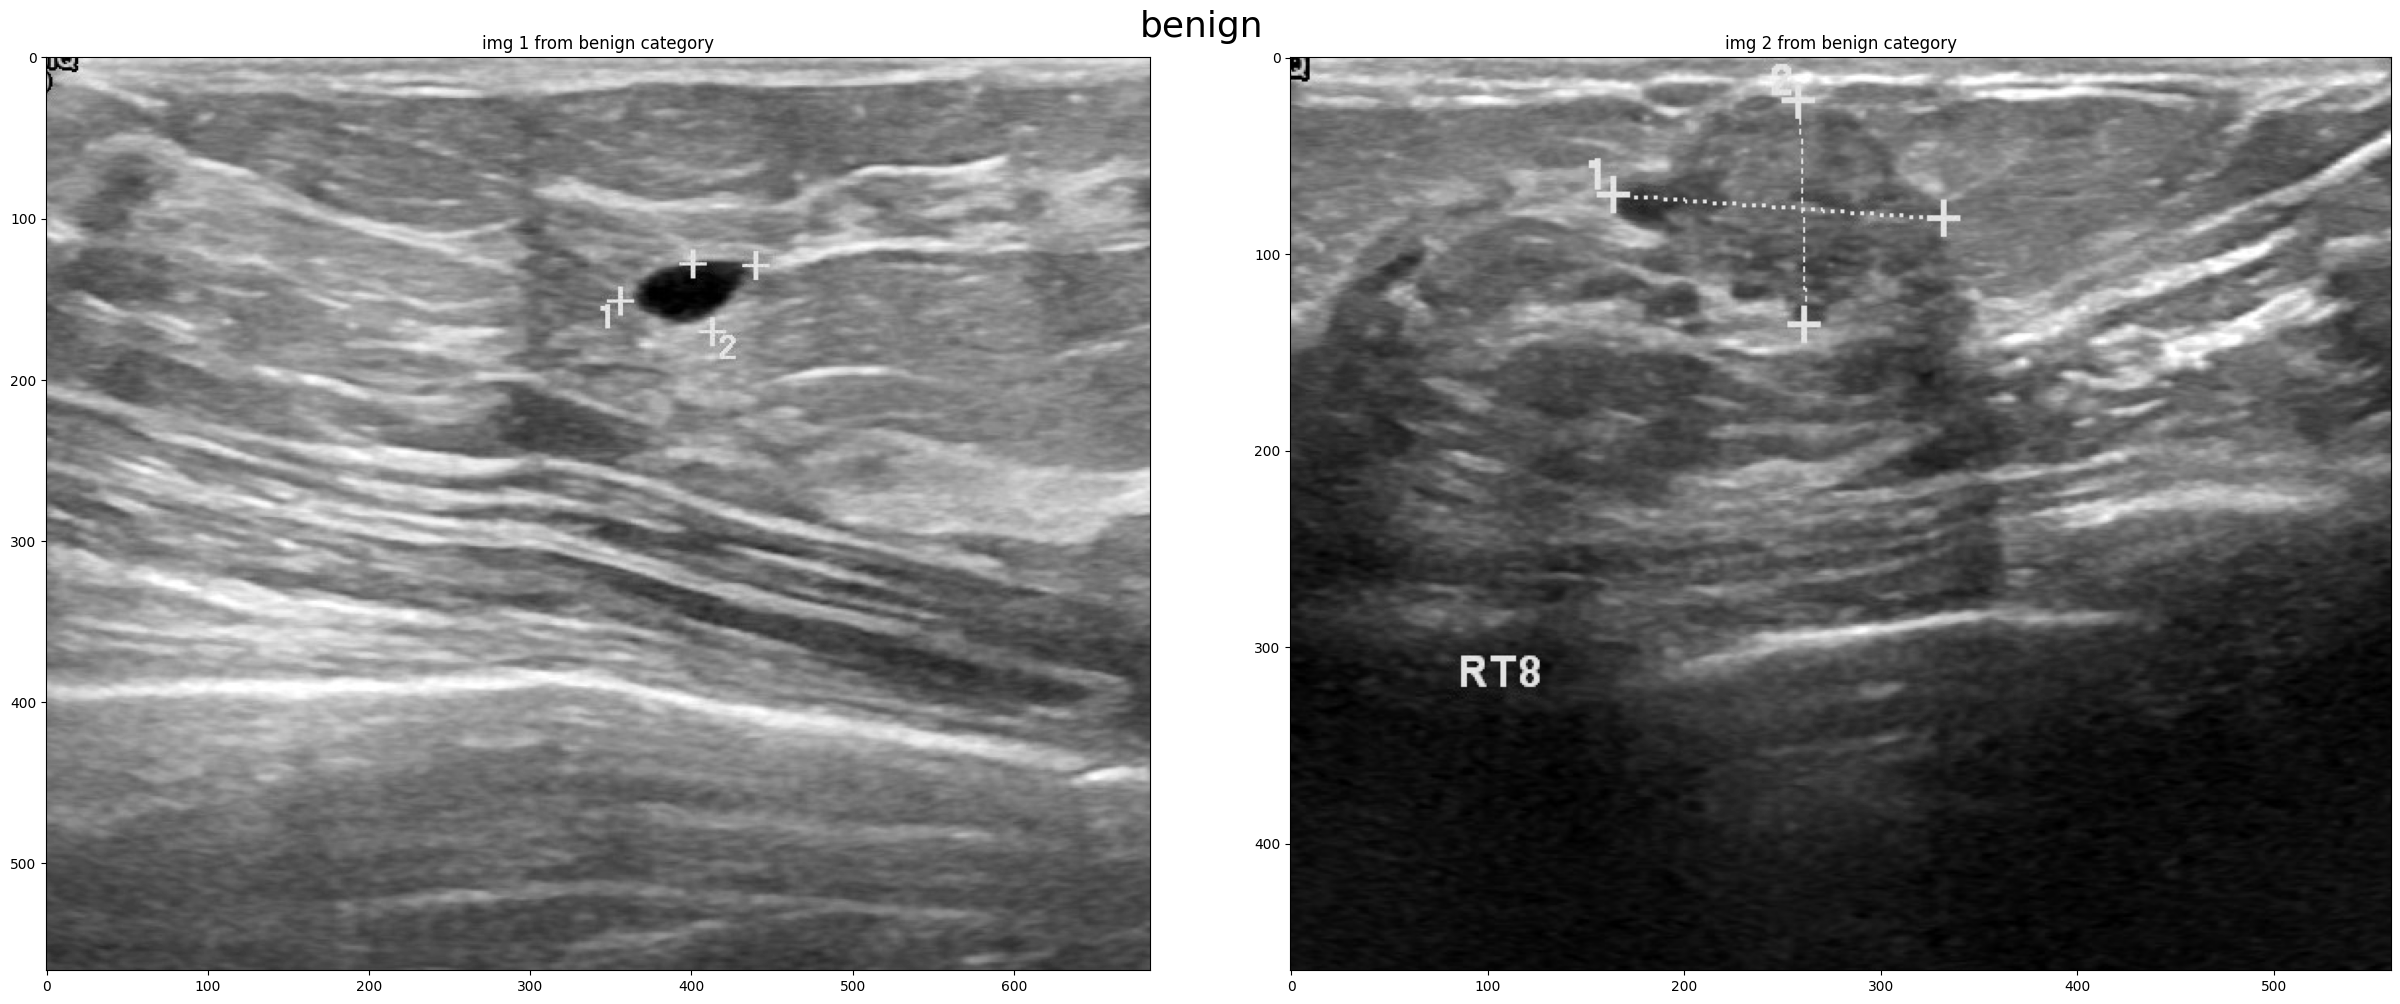

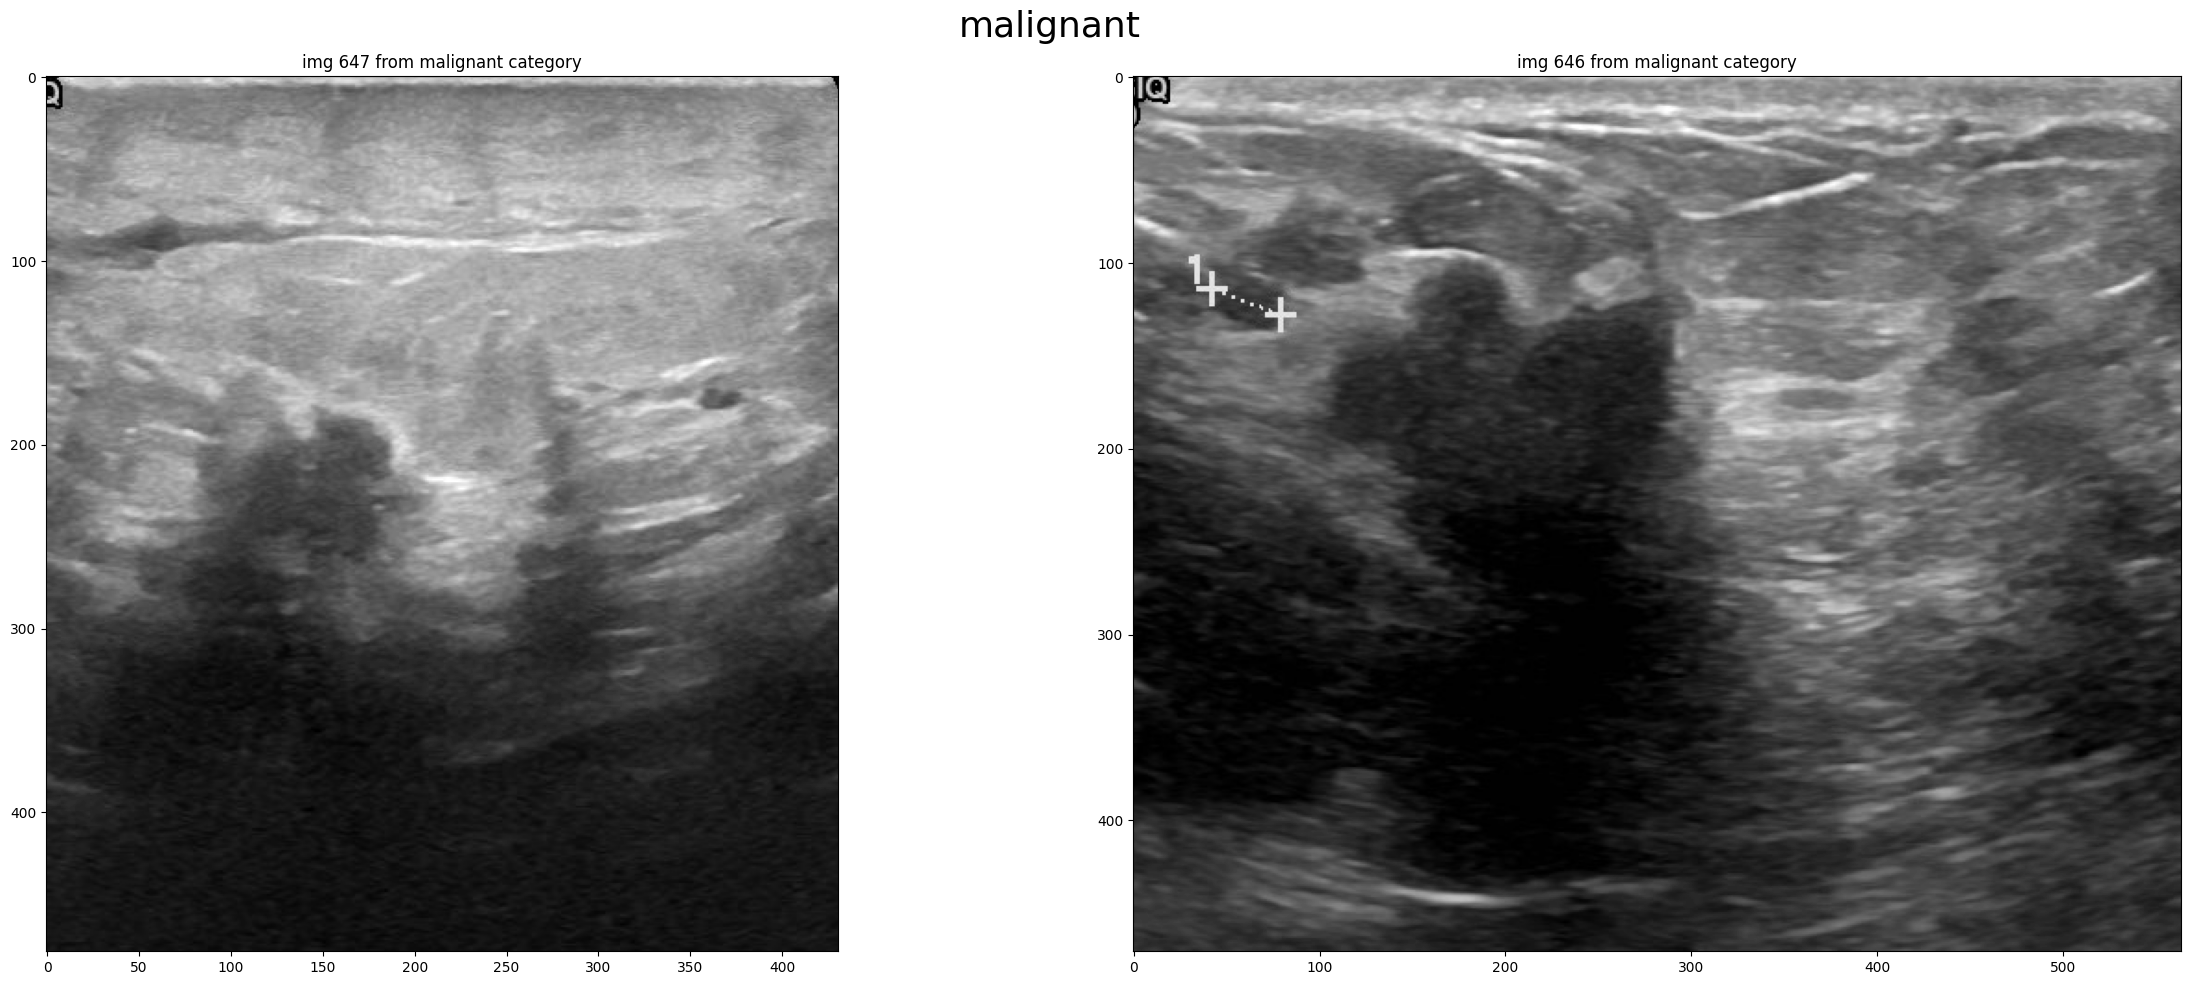

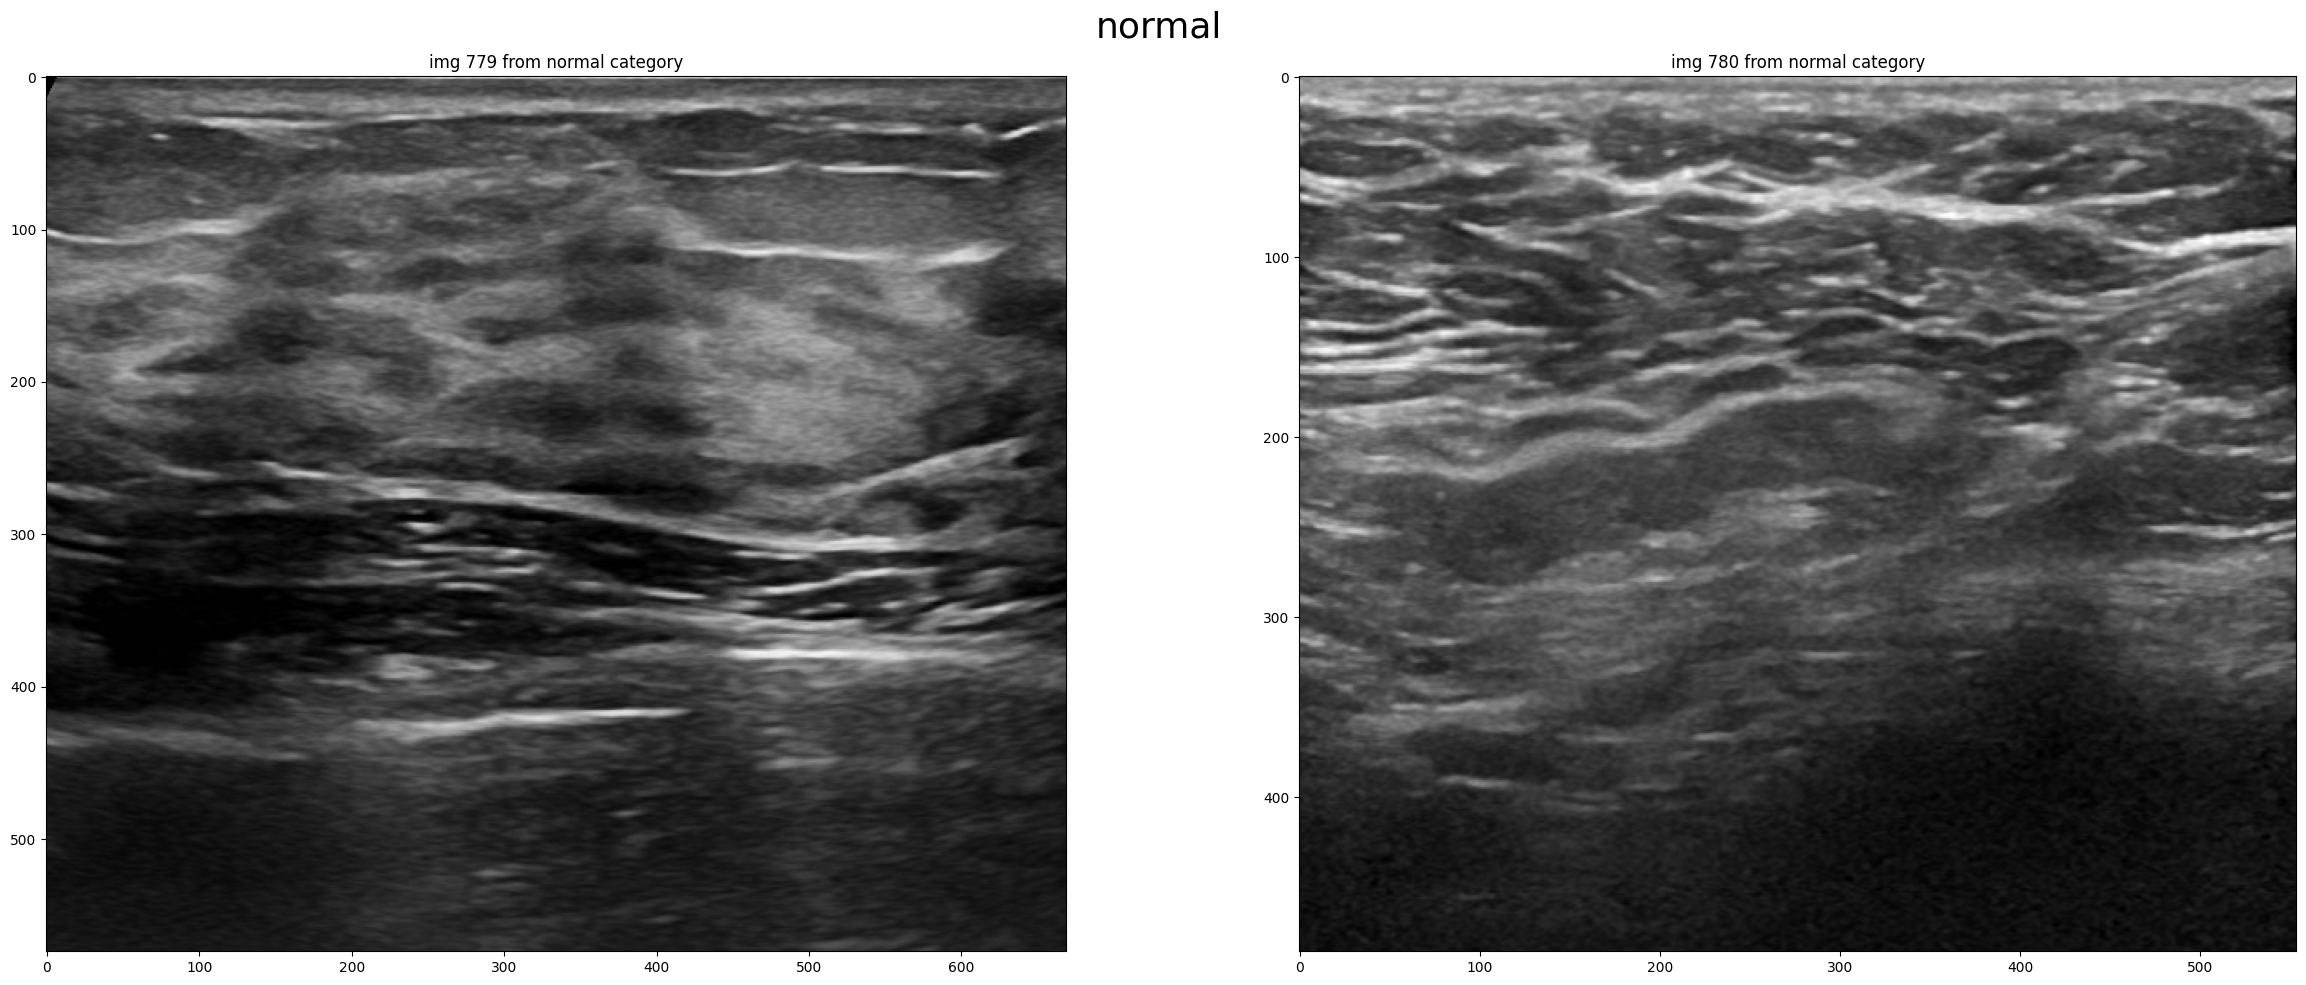

In [53]:
# Reading in and visualising 2 images from each class (Van and Drake, 1995).
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Reading int he file path. 
folder_name = "/Users/hannahcourtney/Downloads/Dataset_BUSI_with_GT"
class_names = ['benign', 'malignant', 'normal']
data = []
labels = []

# Reading images and labels but leaving out the mask files as they contain additional information and may introduce noise. 
for class_name in class_names:
    path = os.path.join(folder_name, class_name)
    for img in os.listdir(path):
        if 'mask' not in img.lower():  
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            data.append(img_array)
            labels.append(class_name)

# Visualising 2 images from each class
for class_name in class_names:
    fig, axes = plt.subplots(1, 2, figsize=(25, 10))  
    for i, (img, label) in enumerate(zip(data, labels)):
        if label == class_name:
            axes[i % 2].imshow(img, cmap='gray')
            axes[i % 2].set_title(f"img {i+1} from {class_name} category")
            if i == 1: 
                break
    plt.suptitle(class_name, fontsize=26)
    plt.tight_layout()
    plt.show()

### Splitting the dataset 

In [54]:
# Spliting the dataset into train and test sets (Van and Drake, 1995).
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# Printing the number of samples in each set to check the dimensions. 
print("Number of samples in X_train:", len(X_train))
print("Number of samples in X_test:", len(X_test))
print("Number of labels in y_train:", len(y_train))
print("Number of labels in y_test:", len(y_test))

Number of samples in X_train: 546
Number of samples in X_test: 234
Number of labels in y_train: 546
Number of labels in y_test: 234


### Checking the class distribution

Class: benign, Count: 299
Class: malignant, Count: 150
Class: normal, Count: 97


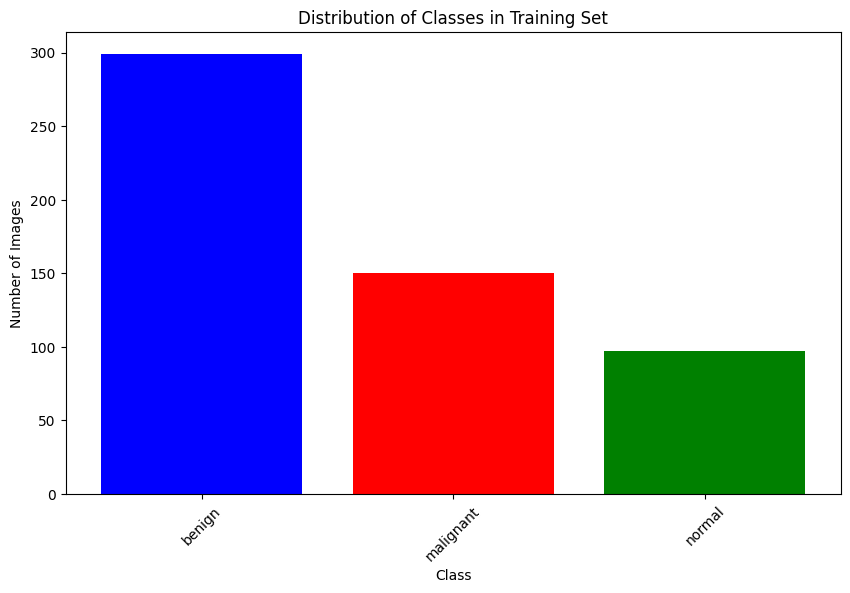

In [55]:
# Initialising a dictionary to store the counts for each class (Van and Drake 1995).
class_counts_train = {class_name: 0 for class_name in class_names}

# Counting the number of images in each class in the training set.
for class_name in class_names:
    class_counts_train[class_name] = sum(1 for label in y_train if label == class_name)

# Printing the count for each class in the training set.
for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

# Plotting the distribution of each class in the training set to visualise.
plt.figure(figsize=(10, 6))
plt.bar(class_counts_train.keys(), class_counts_train.values(), color=['blue', 'red', 'green'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in Training Set')
plt.xticks(rotation=45) 
plt.show()

## Pre-processing

In [56]:
# (Van and Drake 1995)
from PIL import Image 

# Defining the target size for resizing so all images are uniform. 
target_size = (64, 64) 

# Resize the images in X_train
X_train_resized = [Image.fromarray(img).resize(target_size) for img in X_train]

# Resize the images in X_test
X_test_resized = [Image.fromarray(img).resize(target_size) for img in X_test]

# Convert resized images to numpy arrays so they are in the correct format for the models. 
X_train_array = np.array([np.array(img) for img in X_train_resized])
X_test_array = np.array([np.array(img) for img in X_test_resized])

# Normalise the data. This helps to prevent any issues that are related to scaling. 
train_normalized = X_train_array / 255.0
test_normalized = X_test_array / 255.0

print("train shape:", train_normalized.shape)
print("test shape:", test_normalized.shape)

train shape: (546, 64, 64)
test shape: (234, 64, 64)


In [57]:
# (Van and Drake, 1995).
# Convert labels from strings to integers, 
# this adds an extra dimension to be compatible with Keras and changes the class labels to numerical formats (Van and Drake 1995).
from sklearn.preprocessing import LabelEncoder

# Convert class labels to integer labels.
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Check the mapping of original classes to encoded integers.
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class Mapping:", class_mapping)

# Ensure the shape of the data is suitable for Keras
X_train = np.expand_dims(train_normalized, axis=-1)
X_test = np.expand_dims(test_normalized, axis=-1)

# Update labels with encoded ones.
y_train = y_train_encoded
y_test = y_test_encoded

Class Mapping: {'benign': 0, 'malignant': 1, 'normal': 2}


## Convolutional Neural Network 

### Hyperparameter Tuning 

(Van and Drake, 1995).
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Defining the Keras model creation function
def create_model(optimizer='adam', kernel_size=(3, 3), pool_size=(2, 2), dense_units=64):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=kernel_size, activation='relu', input_shape=(64, 64, 1)))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Defining the number of epochs and batch size
epochs = 30
batch_size = 8

# Define the number of folds
n_folds = 10

# Initialising Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# Defining the parameter grid
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'kernel_size': [(3, 3), (5, 5)],
    'pool_size': [(2, 2), (3, 3)],
    'dense_units': [64, 128]
}

# Initialising the best accuracy and best parameters
best_score = 0
best_params = None

# Iterating over each parameter combination 
for optimizer in param_grid['optimizer']:
    for kernel_size in param_grid['kernel_size']:
        for pool_size in param_grid['pool_size']:
            for dense_units in param_grid['dense_units']:
                # Initialize lists to store evaluation metrics from each fold
                accuracy_scores = []
                
                # Perform cross-validation
                for train_index, test_index in skf.split(X_train, y_train):
                    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
                    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
                    
                    # Create and compile the model with the current parameter combination
                    model = create_model(optimizer=optimizer, kernel_size=kernel_size, 
                                          pool_size=pool_size, dense_units=dense_units)
                    
                    # Train the model
                    model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=0)
                    
                    # Evaluate the model
                    _, accuracy = model.evaluate(X_test_fold, y_test_fold, verbose=0)
                    accuracy_scores.append(accuracy)
                
                # Compute the average accuracy for this parameter combination
                mean_accuracy = np.mean(accuracy_scores)
                
                # Update best parameters if the current combination is better
                if mean_accuracy > best_score:
                    best_score = mean_accuracy
                    best_params = {
                        'optimizer': optimizer,
                        'kernel_size': kernel_size,
                        'pool_size': pool_size,
                        'dense_units': dense_units
                    }

# Print the best parameters and best score
print("Best parameters found: ", best_params)
print("Best accuracy found: ", best_score)

# Results:
# Best parameters found:  {'optimizer': 'rmsprop', 'kernel_size': (3, 3), 'pool_size': (3, 3), 'dense_units': 128}
# Best accuracy found:  0.7510101079940796

### CNN using optimised hyperparameters

In [58]:
# (Van and Drake, 1995).
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the Keras model with optimised hyperparameters
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D(pool_size=(3, 3)))  # Changed pool size to (3, 3)
model.add(Flatten())
model.add(Dense(128, activation='relu'))  # Changed dense units to 128
model.add(Dense(3, activation='softmax'))

# Compile the model with optimised hyperparameters
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])  # Changed optimizer to RMSprop

# Define the number of epochs and batch size
epochs = 30
batch_size = 8

# Define the number of folds
n_folds = 10

# Initialize Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# Initialize lists to store evaluation metrics from each fold
accuracy_scores = []
conf_matrices = []

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [59]:
# (Van and Drake, 1995).
# Create an ImageDataGenerator instance for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Average Accuracy: 0.7571043908596039
Average Confusion Matrix:
[[28.8  0.5  0.6]
 [ 6.3  7.9  0.8]
 [ 4.8  0.3  4.6]]
Class 0 - Specificity: 0.9632, Sensitivity: 0.7218
Class 1 - Specificity: 0.5267, Sensitivity: 0.9080
Class 2 - Specificity: 0.4742, Sensitivity: 0.7667
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Confusion Matrix:
[[130   2   6]
 [ 39  16   5]
 [ 17   1  18]]
Accuracy: 0.7008547008547008
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.94      0.80       138
           1       0.84      0.27      0.41        60
           2       0.62      0.50   

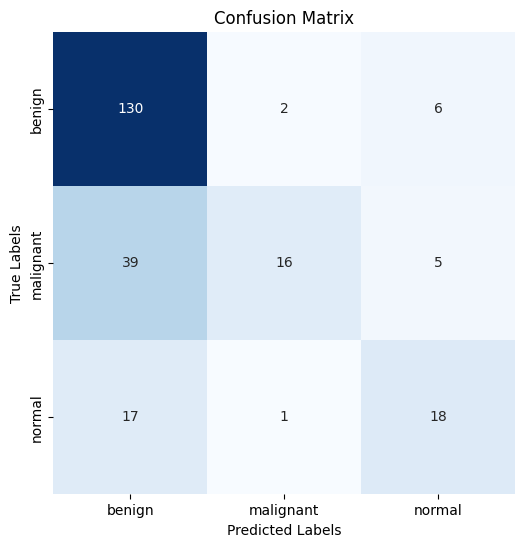

In [60]:
# (Van and Drake, 1995).
def repeat_generator(iterator):
    while True:
        for batch in iterator:
            yield batch

# Perform 10-fold cross-validation.
for train_index, test_index in skf.split(train_normalized, y_train_encoded):
    # Split data into train and validation sets for this fold
    X_train_fold, X_val_fold = train_normalized[train_index], train_normalized[test_index]
    y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[test_index]
    
    # Generate augmented data for training using datagen.
    train_datagen = datagen.flow(X_train_fold.reshape(-1, 64, 64, 1), y_train_fold, batch_size=batch_size)
    
    # Define the number of steps per epoch.
    steps_per_epoch = len(X_train_fold) // batch_size
    
    # Create a custom generator that yields batches indefinitely.
    train_generator = repeat_generator(train_datagen)

    # Train the model on augmented data for this fold.
    model.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=(X_val_fold, y_val_fold), verbose=0)
    
    # Evaluate the model on the validation set for this fold.
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    accuracy_scores.append(val_accuracy)
    
    # Predictions on the validation set for this fold.
    y_pred_fold = np.argmax(model.predict(X_val_fold), axis=1)
    conf_matrix_fold = confusion_matrix(y_val_fold, y_pred_fold)
    conf_matrices.append(conf_matrix_fold)

# Average accuracy over all folds.
average_accuracy = np.mean(accuracy_scores)
print("Average Accuracy:", average_accuracy)

# Average confusion matrix over all folds.
average_conf_matrix = np.mean(conf_matrices, axis=0)
print("Average Confusion Matrix:")
print(average_conf_matrix)

# Calculate specificity and sensitivity for each class.
specificity = np.diag(average_conf_matrix) / np.sum(average_conf_matrix, axis=1)
sensitivity = np.diag(average_conf_matrix) / np.sum(average_conf_matrix, axis=0)

# Print specificity and sensitivity for each class.
for i, (spec, sens) in enumerate(zip(specificity, sensitivity)):
    print(f"Class {i} - Specificity: {spec:.4f}, Sensitivity: {sens:.4f}")

# Predict probabilities for each class for test set.
y_pred_prob = model.predict(test_normalized)

# Convert probabilities to class labels.
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate confusion matrix.
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

# Print confusion matrix.
print("Confusion Matrix:")
print(conf_matrix)

# Calculate accuracy.
accuracy = accuracy_score(y_test_encoded, y_pred)

# Print accuracy.
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred))

# Plot confusion matrix as a heatmap.
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Fully Connected Neural Network

## Hyperparameter tuning

# (Van and Drake, 1995).
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
import numpy as np

# Define the number of epochs and batch size
epochs = 30
batch_size = 8

# Define the number of folds
n_folds = 10

# Initialise Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'neurons_layer1': [64, 128, 256],
    'neurons_layer2': [32, 64, 128]
}

# Initialise best accuracy and best parameters
best_score = 0
best_params = None

# Iterate over each parameter combination
for learning_rate in param_grid['learning_rate']:
    for neurons_layer1 in param_grid['neurons_layer1']:
        for neurons_layer2 in param_grid['neurons_layer2']:
            # Initialize lists to store evaluation metrics from each fold
            accuracy_scores = []
            
            # Perform cross-validation
            for train_index, test_index in skf.split(train_normalized, y_train_encoded):
                X_train_fold, X_val_fold = train_normalized[train_index], train_normalized[test_index]
                y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[test_index]
                
                # Define the Keras model with current parameter combination
                model = Sequential([
                    Flatten(input_shape=(64, 64, 1)),
                    Dense(neurons_layer1, activation='relu'),
                    Dense(neurons_layer2, activation='relu'),
                    Dense(3, activation='softmax')
                ])
                
                # Compile the model with current learning rate
                optimizer = Adam(learning_rate=learning_rate)
                model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
                
                # Train the model
                history = model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=0)
                
                # Evaluate the model on the validation set
                val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
                accuracy_scores.append(val_accuracy)
            
            # Compute average accuracy for this parameter combination
            mean_accuracy = np.mean(accuracy_scores)
            
            # Update best parameters if the current combination is better
            if mean_accuracy > best_score:
                best_score = mean_accuracy
                best_params = {
                    'learning_rate': learning_rate,
                    'neurons_layer1': neurons_layer1,
                    'neurons_layer2': neurons_layer2
                }

# Print the best parameters and best score
print("Best parameters found: ", best_params)
print("Best accuracy found: ", best_score)
#Best parameters found:  {'learning_rate': 0.001, 'neurons_layer1': 64, 'neurons_layer2': 64}
#Best accuracy found:  0.6779461234807969

### FCNN with optimised hyperparameters

In [61]:
# (Van and Drake, 1995).
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the Keras model with the optimal hyperparameters.
model = Sequential()
model.add(Flatten(input_shape=(64, 64, 1)))  # Flattening the input image
model.add(Dense(64, activation='relu'))     # Dense layer with 64 neurons and ReLU activation
model.add(Dense(64, activation='relu'))     # Dense layer with 64 neurons and ReLU activation
model.add(Dense(3, activation='softmax'))   # Output layer with 3 neurons for classification

# Compile the model with best hyperparameters.
optimizer = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define the number of epochs and batch size.
epochs = 30
batch_size = 8

# Define the number of folds.
n_folds = 10

# Initialise Stratified K-Fold cross-validator.
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# Initialise lists to store evaluation metrics from each fold.
accuracy_scores = []
conf_matrices = []

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [62]:
# Creating an ImageDataGenerator instance for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    shear_range=0.1,  
    zoom_range=0.1,  
    horizontal_flip=True,  
    vertical_flip=True,  
    fill_mode='nearest'  
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-01 18:39:07.226905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-05-01 18:39:07.372964: W tensorflow/core/framework/loc

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

2024-05-01 18:39:09.178388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 18:39:09.314549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-01 18:39:09.560699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-05-01 18:39:09.695410: W tensorflow/core/framework/loc

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-05-01 18:39:11.319751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 18:39:11.451545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-01 18:39:11.664046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-01 18:39:13.975021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-05-01 18:39:14.116479: W tensorflow/core/framework/loc

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step


2024-05-01 18:39:15.724528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 18:39:15.859116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-01 18:39:16.065780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step


2024-05-01 18:39:17.803192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 18:39:17.937190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-01 18:39:18.144799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step


2024-05-01 18:39:19.870503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 18:39:20.001829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-01 18:39:20.218550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step


2024-05-01 18:39:21.955963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 18:39:22.087724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-01 18:39:22.292901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step


2024-05-01 18:39:24.019227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 18:39:24.151010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-01 18:39:24.357948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step


2024-05-01 18:39:26.070374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 18:39:26.200773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-01 18:39:26.407928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step


2024-05-01 18:39:28.168886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 18:39:28.301004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Average Accuracy: 0.6611784338951111
Average Confusion Matrix:
[[28.1  1.7  0.1]
 [ 7.   8.   0. ]
 [ 8.8  0.9  0. ]]
Class 0 - Specificity: 0.9398, Sensitivity: 0.6401
Class 1 - Specificity: 0.5333, Sensitivity: 0.7547
Class 2 - Specificity: 0.0000, Sensitivity: 0.0000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step
Confusion Matrix:
[[129   9   0]
 [ 31  29   0]
 [ 34   2   0]]
Accuracy: 0.6752136752136753
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.93      0.78       138
           1       0.72      0.48      0.58        60
           2       0.00      0.00      0.00        36

    accuracy                           0.68       234
   macro avg       0.46      0.47      0.45       234
weighted avg       0.58      0.68      0.61       234



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Text(0.5, 1.0, 'Confusion Matrix')

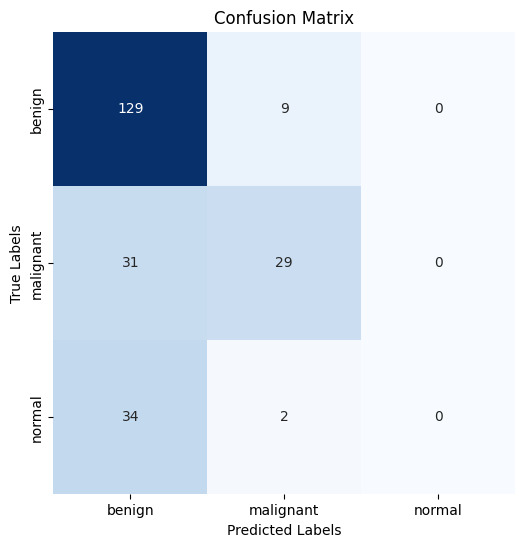

In [63]:
# Perform 10-fold cross-validation
for train_index, test_index in skf.split(train_normalized, y_train_encoded):
    
    # Split data into train and validation sets for this fold.
    X_train_fold, X_val_fold = train_normalized[train_index], train_normalized[test_index]
    y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[test_index]
    
    # Generate augmented data for training using datagen.
    train_datagen = datagen.flow(X_train_fold.reshape(-1, 64, 64, 1), y_train_fold, batch_size=batch_size)
    
    # Define the number of steps per epoch.
    steps_per_epoch = len(X_train_fold) // batch_size
    
    # Train the model on augmented data for this fold.
    history = model.fit(train_datagen, epochs=epochs, steps_per_epoch=steps_per_epoch,
                        validation_data=(X_val_fold, y_val_fold), verbose=0)
    
    # Evaluate the model on the validation set for this fold.
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    accuracy_scores.append(val_accuracy)
    
    # Predictions on the validation set for this fold.
    y_pred_fold = np.argmax(model.predict(X_val_fold), axis=1)
    conf_matrix_fold = confusion_matrix(y_val_fold, y_pred_fold)
    conf_matrices.append(conf_matrix_fold)

# Average accuracy over all folds.
average_accuracy = np.mean(accuracy_scores)
print("Average Accuracy:", average_accuracy)

# Average confusion matrix over all folds.
average_conf_matrix = np.mean(conf_matrices, axis=0)
print("Average Confusion Matrix:")
print(average_conf_matrix)

# Calculate specificity and sensitivity for each class.
specificity = np.diag(average_conf_matrix) / np.sum(average_conf_matrix, axis=1)
sensitivity = np.diag(average_conf_matrix) / np.sum(average_conf_matrix, axis=0)

# Print specificity and sensitivity for each class.
for i, (spec, sens) in enumerate(zip(specificity, sensitivity)):
    print(f"Class {i} - Specificity: {spec:.4f}, Sensitivity: {sens:.4f}")

# Predict probabilities for each class for test set.
y_pred_prob = model.predict(test_normalized)

# Convert probabilities to class labels.
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate confusion matrix.
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

# Print confusion matrix.
print("Confusion Matrix:")
print(conf_matrix)

# Calculate accuracy.
accuracy = accuracy_score(y_test_encoded, y_pred)

# Print accuracy.
print("Accuracy:", accuracy)

# Print classification report.
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred))

# Plot confusion matrix as a heatmap.
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Support Vector Machine 

In [64]:
# (Van and Drake, 1995).
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define the SVM model
svm_model = SVC()

# Define the hyperparameters grid
param_grid = {
    'C': [0.1, 1, 10, 100],    # Regularisation parameter
    'gamma': ['scale', 'auto'], # Kernel coefficient
    'kernel': ['linear', 'rbf'] # Kernel type
}

# Define the number of folds
n_folds = 10

# Initialise Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# Perform GridSearchCV with 10-fold cross-validation
svm_grid_search = GridSearchCV(svm_model, param_grid, cv=skf, scoring='accuracy')

# Fit the GridSearchCV object to the data
svm_grid_search.fit(train_normalized.reshape(train_normalized.shape[0], -1), y_train_encoded)

# Print the best hyperparameters
print("Best Hyperparameters:", svm_grid_search.best_params_)

Best Hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Average Accuracy from 10-fold cross-validation: 0.7457239057239058
SVM Model Accuracy on Test Data: 0.717948717948718
Class 0: Sensitivity=0.8188405797101449, Specificity=0.773972602739726
Class 1: Sensitivity=0.6, Specificity=0.6666666666666666
Class 2: Sensitivity=0.5277777777777778, Specificity=0.5588235294117647
Confusion Matrix:
[[113  15  10]
 [ 19  36   5]
 [ 14   3  19]]


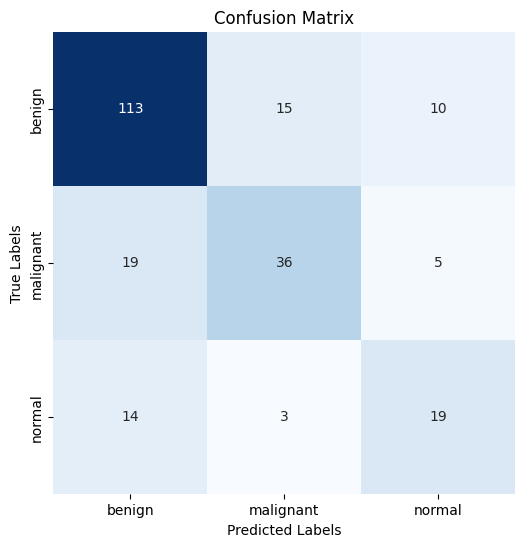

In [65]:
# (Van and Drake, 1995).
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the SVM model with optimised hyperparameters
best_svm_model = SVC(C=10, gamma='scale', kernel='rbf')

# Define the number of folds
n_folds = 10

# Initialise Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# Perform cross-validation
cv_scores = cross_val_score(best_svm_model, train_normalized.reshape(train_normalized.shape[0], -1), y_train_encoded, cv=skf)

# Calculate average accuracy
average_accuracy = np.mean(cv_scores)
print("Average Accuracy from 10-fold cross-validation:", average_accuracy)

# Fit the model to the entire training data
best_svm_model.fit(train_normalized.reshape(train_normalized.shape[0], -1), y_train_encoded)

# Predict on the test data
y_pred_svm = best_svm_model.predict(test_normalized.reshape(test_normalized.shape[0], -1))

# Calculate accuracy on the test data
accuracy_svm = accuracy_score(y_test_encoded, y_pred_svm)
print("SVM Model Accuracy on Test Data:", accuracy_svm)

# Calculate sensitivity and specificity for each class
def calculate_sensitivity_specificity(conf_matrix):
    sensitivity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    specificity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
    return sensitivity, specificity

# Calculate sensitivity and specificity
sensitivity, specificity = calculate_sensitivity_specificity(conf_matrix_svm)

# Print sensitivity and specificity for each class
for i, (sens, spec) in enumerate(zip(sensitivity, specificity)):
    print(f"Class {i}: Sensitivity={sens}, Specificity={spec}")

# Calculate confusion matrix
conf_matrix_svm = confusion_matrix(y_test_encoded, y_pred_svm)
print("Confusion Matrix:")
print(conf_matrix_svm)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# K-Nearest Neighbours 

Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Average Accuracy from 10-fold cross-validation: 0.6519191919191919
KNN Model Accuracy: 0.6623931623931624
Confusion Matrix:
[[93 27 18]
 [15 38  7]
 [11  1 24]]
Class 0: Sensitivity=0.6739130434782609, Specificity=0.7815126050420168
Class 1: Sensitivity=0.6333333333333333, Specificity=0.5757575757575758
Class 2: Sensitivity=0.6666666666666666, Specificity=0.4897959183673469


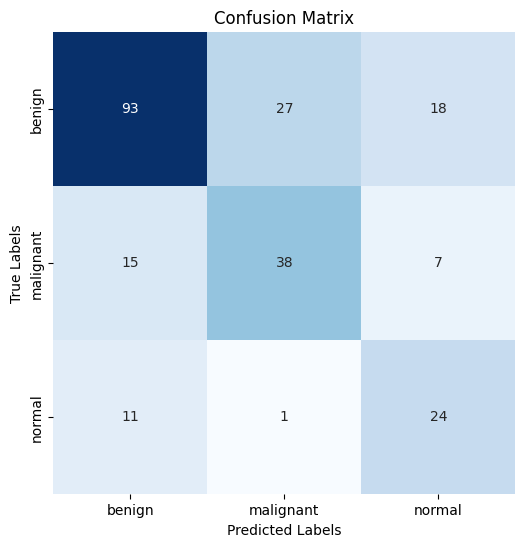

In [66]:
# (Van and Drake, 1995).
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the KNN model
knn_model = KNeighborsClassifier()

# Define the hyperparameters grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function
    'metric': ['euclidean', 'manhattan']  # Distance metric
}

# Define the number of folds
n_folds = 10

# Initialise Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# Perform GridSearchCV with 10-fold cross-validation
knn_grid_search = GridSearchCV(knn_model, param_grid, cv=skf, scoring='accuracy')

# Fit the GridSearchCV object to the data
knn_grid_search.fit(train_normalized.reshape(train_normalized.shape[0], -1), y_train_encoded)

# Print the best hyperparameters
print("Best Hyperparameters:", knn_grid_search.best_params_)

# Get the best KNN model
best_knn_model = knn_grid_search.best_estimator_

# Perform 10-fold cross-validation to get average accuracy
cv_scores = cross_val_score(best_knn_model, train_normalized.reshape(train_normalized.shape[0], -1), y_train_encoded, cv=skf)
average_cv_accuracy = cv_scores.mean()
print("Average Accuracy from 10-fold cross-validation:", average_cv_accuracy)

# Evaluate the best KNN model
y_pred_knn = best_knn_model.predict(test_normalized.reshape(test_normalized.shape[0], -1))

# Calculate accuracy
accuracy_knn = accuracy_score(y_test_encoded, y_pred_knn)
print("KNN Model Accuracy:", accuracy_knn)

# Calculate confusion matrix
conf_matrix_knn = confusion_matrix(y_test_encoded, y_pred_knn)
print("Confusion Matrix:")
print(conf_matrix_knn)

# Calculate sensitivity and specificity for each class
sensitivity = np.diag(conf_matrix_knn) / np.sum(conf_matrix_knn, axis=1)
specificity = np.diag(conf_matrix_knn) / np.sum(conf_matrix_knn, axis=0)

# Print sensitivity and specificity for each class
for i, (sens, spec) in enumerate(zip(sensitivity, specificity)):
    print(f"Class {i}: Sensitivity={sens}, Specificity={spec}")

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# AdaBoost 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R

Best Hyperparameters: {'learning_rate': 1.0, 'n_estimators': 150}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R

Average Accuracy from 10-fold cross-validation: 0.6119865319865319
AdaBoost Model Accuracy: 0.6452991452991453
Confusion Matrix:
[[122   9   7]
 [ 33  23   4]
 [ 30   0   6]]
Class 0: Sensitivity=0.8840579710144928, Specificity=0.6594594594594595
Class 1: Sensitivity=0.38333333333333336, Specificity=0.71875
Class 2: Sensitivity=0.16666666666666666, Specificity=0.35294117647058826


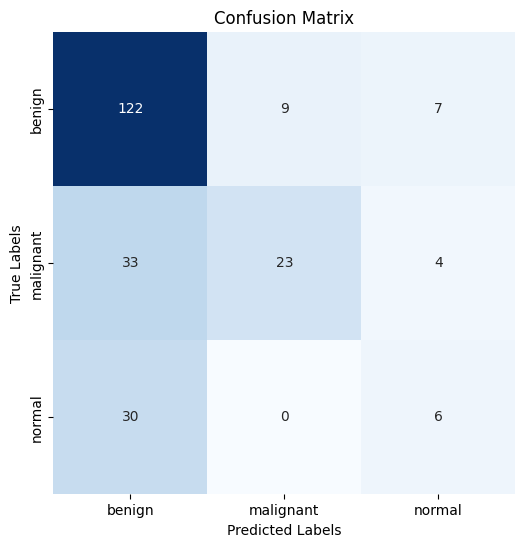

In [67]:
# (Van and Drake, 1995).
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the AdaBoost model
ada_boost_model = AdaBoostClassifier()

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of estimators
    'learning_rate': [0.1, 0.5, 1.0]  # Learning rate
}

# Define the number of folds
n_folds = 10

# Initialise Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# Perform GridSearchCV with 10-fold cross-validation
ada_boost_grid_search = GridSearchCV(ada_boost_model, param_grid, cv=skf, scoring='accuracy')

# Fit the GridSearchCV object to the data
ada_boost_grid_search.fit(train_normalized.reshape(train_normalized.shape[0], -1), y_train_encoded)

# Print the best hyperparameters
print("Best Hyperparameters:", ada_boost_grid_search.best_params_)

# Get the best AdaBoost model
best_ada_boost_model = ada_boost_grid_search.best_estimator_

# Perform 10-fold cross-validation to get average accuracy
cv_scores = cross_val_score(best_ada_boost_model, train_normalized.reshape(train_normalized.shape[0], -1), y_train_encoded, cv=skf)
average_cv_accuracy = cv_scores.mean()
print("Average Accuracy from 10-fold cross-validation:", average_cv_accuracy)

# Evaluating the best AdaBoost model to use
y_pred_ada_boost = best_ada_boost_model.predict(test_normalized.reshape(test_normalized.shape[0], -1))

# Calculating the accuracy
accuracy_ada_boost = accuracy_score(y_test_encoded, y_pred_ada_boost)
print("AdaBoost Model Accuracy:", accuracy_ada_boost)

# Calculating the confusion matrix
conf_matrix_ada_boost = confusion_matrix(y_test_encoded, y_pred_ada_boost)
print("Confusion Matrix:")
print(conf_matrix_ada_boost)

# Calculating sensitivity and specificity for each class
sensitivity = np.diag(conf_matrix_ada_boost) / np.sum(conf_matrix_ada_boost, axis=1)
specificity = np.diag(conf_matrix_ada_boost) / np.sum(conf_matrix_ada_boost, axis=0)

# Printing sensitivity and specificity for each class
for i, (sens, spec) in enumerate(zip(sensitivity, specificity)):
    print(f"Class {i}: Sensitivity={sens}, Specificity={spec}")

# Plotting confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ada_boost, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [68]:
# (Van and Drake, 1995).
# Confusion matrix for each classifier
confusion_matrix_cnn = [[117, 6, 15],
                        [22, 33, 5],
                        [12, 0, 24]]

confusion_matrix_fcnn = [[28.5, 1.4, 0],
                         [9.1, 5.9, 0],
                         [9, 0.7, 0]]

confusion_matrix_svm = [[113, 15, 10],
                        [19, 36, 5],
                        [14, 3, 19]]

confusion_matrix_knn = [[98, 18, 22],
                        [13, 40, 7],
                        [13, 2, 21]]

confusion_matrix_adaboost = [[112, 11, 15],
                              [34, 20, 6],
                              [25, 0, 11]]

# Combining each classifer confusion matrix
confusion_matrices_top = {
    'CNN': confusion_matrix_cnn,
    'FCNN': confusion_matrix_fcnn,
    'SVM': confusion_matrix_svm,
}
confusion_matrices_bottom = {
    'KNN': confusion_matrix_knn,
    'Adaboost': confusion_matrix_adaboost
}

# Converting to a Pandas DataFrame for visualisation.
df_top = pd.DataFrame(confusion_matrices_top, index=['Benign (0)', 'Malignant (1)', 'Normal (2)'])
df_bottom = pd.DataFrame(confusion_matrices_bottom, index=['Benign (0)', 'Malignant (1)', 'Normal (2)'])

# Display as a table.
print(df_top)
print('\n')
print(df_bottom)

                        CNN            FCNN            SVM
Benign (0)     [117, 6, 15]  [28.5, 1.4, 0]  [113, 15, 10]
Malignant (1)   [22, 33, 5]   [9.1, 5.9, 0]    [19, 36, 5]
Normal (2)      [12, 0, 24]     [9, 0.7, 0]    [14, 3, 19]


                        KNN       Adaboost
Benign (0)     [98, 18, 22]  [112, 11, 15]
Malignant (1)   [13, 40, 7]    [34, 20, 6]
Normal (2)      [13, 2, 21]    [25, 0, 11]
